In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Downloading CIFAR-10
import numpy as np
import os
import requests
import tarfile
import pickle

# Model definition
from dl import Module
from dl.modules import Convolution, ReLU, Linear, Flatten, MaxPool

# Training
from dl import Variable
from dl.data import BatchLoader, train_val_split, accuracy
from dl.data.transforms import ComposeTransforms, ToFloat, ToVariable, RandomCrop, RandomHorizontalFlip, Normalize3D
from dl.optimizers import SGD, LRScheduler
from dl.functions import cross_entropy_loss

# Output
from tqdm import tqdm
import matplotlib.pyplot as plt

## Download and extract CIFAR-10.

In [3]:
root = './data'
url = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
filename = 'cifar-10-python.tar.gz'
archive_path = os.path.join(root, filename)
extract_path = os.path.join(root, 'cifar-10-batches-py')

os.makedirs(root, exist_ok=True)

# Download compressed file containing dataset.
if not os.path.exists(archive_path):
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(archive_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)

# Extract dataset from compressed file.
if not os.path.exists(extract_path):
    with tarfile.open(archive_path, 'r:gz') as tar:
        tar.extractall(path=os.path.dirname(extract_path))

print(f"\nCIFAR-10 is ready at: {extract_path}")


CIFAR-10 is ready at: ./data/cifar-10-batches-py


## Load CIFAR-10 into ram.

In [4]:
def load_cifar_batch(batch_path):
    with open(batch_path, 'rb') as fo:
        batch = pickle.load(fo, encoding='bytes')
        X = batch[b'data'] # shape (10000, 3072)
        X = X.reshape(-1, 3, 32, 32).astype(np.float32)
        y = np.array(batch[b'labels']) # list of 10000 ints

    return X, y

# Iterate over all 5 batch files.
xs = []
ys = []
for i in range(1, 6): 
    batch_path = os.path.join(extract_path, f'data_batch_{i}')
    with open(batch_path, 'rb') as fo:
        X, y = load_cifar_batch(batch_path)

    xs.append(X)
    ys.append(y)

X_train_full = np.concatenate(xs)  # shape (50000, 3, 32, 32)
y_train_full = np.concatenate(ys)
X_test, y_test = load_cifar_batch(os.path.join(extract_path, 'test_batch'))

# Set aside a validation set.
X_train, y_train, X_val, y_val = train_val_split(X_train_full, y_train_full, ratio=0.1, seed=42)

## Define Transforms and Augmentations.

In [5]:
# Compute normalization statistics.
X_for_stats = X_train.astype(np.float32) / 255.0
mean = np.mean(X_for_stats, axis=(0, 2, 3))
std = np.std(X_for_stats, axis=(0, 2, 3))


train_image_transforms = ComposeTransforms([RandomCrop(32), RandomHorizontalFlip(0.5), ToFloat(255.0), Normalize3D(mean, std), ToVariable()])
val_image_transforms = ComposeTransforms([ToFloat(255.0), Normalize3D(mean, std), ToVariable()])
label_transforms = ToVariable()


## Create BatchLoaders.

In [6]:
class Cifar10:
    
    def __init__(self, images, labels, image_transforms=None, label_transforms=None):
        super().__init__()
        
        self.images = images
        self.labels = labels
        self.image_transforms = image_transforms
        self.label_transforms = label_transforms
        
    def __getitem__(self, idx):
        
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.image_transforms is not None:
            image = self.image_transforms(image)
        
        if self.label_transforms is not None:
            label = self.label_transforms(label)
            
        return image, label
        
    def __len__(self):
        return self.images.shape[0]

In [7]:
BATCH_SIZE = 64

batchloaders = {}
batchloaders['train'] = BatchLoader(Cifar10(X_train, y_train, train_image_transforms, label_transforms), batch_size=BATCH_SIZE, shuffle=True)
batchloaders['val'] = BatchLoader(Cifar10(X_val, y_val, val_image_transforms, label_transforms), batch_size=BATCH_SIZE, shuffle=False)
batchloaders['test'] = BatchLoader(Cifar10(X_test, y_test, val_image_transforms, label_transforms), batch_size=BATCH_SIZE, shuffle=False)

## Define the CNN architecture.

In [8]:
class CNN(Module):
    def __init__(self):
        super().__init__()
        
        # Conv Block 1
        self.conv1 = Convolution(C_in=3, C_out=32, K=3, stride=1, padding=1)
        self.relu1 = ReLU()
        self.pool1 = MaxPool(K=2, stride=2)  # 32x32 → 16x16

        # Conv Block 2
        self.conv2 = Convolution(C_in=32, C_out=64, K=3, stride=1, padding=1)
        self.relu2 = ReLU()
        self.pool2 = MaxPool(K=2, stride=2)  # 16x16 → 8x8

        # Conv Block 3
        self.conv3 = Convolution(C_in=64, C_out=128, K=3, stride=1, padding=1)
        self.relu3 = ReLU()
        self.pool3 = MaxPool(K=2, stride=2)  # 8x8 → 4x4

        self.flat = Flatten()
        self.fc1 = Linear(128 * 4 * 4, 256)
        self.relu4 = ReLU()
        self.fc2 = Linear(256, 10)  # CIFAR-10 output

    def forward(self, X):
        X = self.pool1(self.relu1(self.conv1(X)))
        X = self.pool2(self.relu2(self.conv2(X)))
        X = self.pool3(self.relu3(self.conv3(X)))
        X = self.flat(X)
        X = self.relu4(self.fc1(X))
        X = self.fc2(X)
        return X

## Train the CNN.

In [9]:
learning_rate_schedule = {0: 0.005, 17: 0.002, 25: 0.0005}

model = CNN()
optimizer = SGD(model.parameters(), weight_decay=2e-4 , momentum=0.9)
scheduler = LRScheduler(optimizer, learning_rate_schedule)

In [10]:
epochs = 30
train_losses = []
val_losses = []

train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    
    print(f"\nEpoch {epoch + 1}/{epochs}")
    
    # Train
    
    train_loss = 0
    train_correct = 0
    train_total = 0
    model.enable_grad()
    pbar = tqdm(batchloaders['train'], desc="Training", leave=False)
    for X_batch, y_batch in pbar:
        
        # Compute features and loss.
        features = model(X_batch)
        loss = cross_entropy_loss(features, y_batch)
       
        # Update model parameters.
        optimizer.clear_grad()
        loss.backward()
        optimizer.update_parameters()
    
        train_loss += loss.data * len(y_batch.data)
        train_correct += accuracy(features, y_batch)
        train_total += len(y_batch.data)
        
        # Update tqdm bar with batch loss
        pbar.set_postfix(loss=loss.data)
        
    train_losses.append(train_loss / train_total)
    train_accuracies.append(train_correct / train_total)
    scheduler.step()
    
    # Validate
    
    val_loss = 0
    val_correct = 0
    val_total = 0
    model.disable_grad()
    for X_batch, y_batch in tqdm(batchloaders['val'], desc="Validating", leave=False):
        
        features = model(X_batch)
        loss = cross_entropy_loss(features, y_batch)
        
        val_loss += loss.data * len(y_batch.data)
        val_correct += accuracy(features, y_batch)
        val_total += len(y_batch.data)
        
    val_losses.append(val_loss / val_total)
    val_accuracies.append(val_correct / val_total)
    print(f"Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}")


Epoch 1/30


Train Loss: 1.5585 | Val Loss: 1.3245

Epoch 2/30


Train Loss: 1.1275 | Val Loss: 1.0738

Epoch 3/30


Train Loss: 1.0110 | Val Loss: 1.0602

Epoch 4/30


Train Loss: 0.9246 | Val Loss: 0.9107

Epoch 5/30


Train Loss: 0.8667 | Val Loss: 0.9251

Epoch 6/30


Train Loss: 0.8195 | Val Loss: 0.8422

Epoch 7/30


Train Loss: 0.7876 | Val Loss: 0.8591

Epoch 8/30


Train Loss: 0.7449 | Val Loss: 0.8551

Epoch 9/30


Train Loss: 0.7106 | Val Loss: 0.7591

Epoch 10/30


Train Loss: 0.6878 | Val Loss: 0.8027

Epoch 11/30


Train Loss: 0.6659 | Val Loss: 0.7264

Epoch 12/30


Train Loss: 0.6438 | Val Loss: 0.7206

Epoch 13/30


Train Loss: 0.6238 | Val Loss: 0.7876

Epoch 14/30


Train Loss: 0.6071 | Val Loss: 0.6922

Epoch 15/30


Train Loss: 0.5823 | Val Loss: 0.6780

Epoch 16/30


Train Loss: 0.5712 | Val Loss: 0.6833

Epoch 17/30


Train Loss: 0.5529 | Val Loss: 0.6984

Epoch 18/30


Train Loss: 0.5351 | Val Loss: 0.6557

Epoch 19/30


Train Loss: 0.4550 | Val Loss: 0.6128

Epoch 20/30


Train Loss: 0.4401 | Val Loss: 0.6003

Epoch 21/30


Train Loss: 0.4303 | Val Loss: 0.6129

Epoch 22/30


Train Loss: 0.4138 | Val Loss: 0.6312

Epoch 23/30


Train Loss: 0.4087 | Val Loss: 0.6194

Epoch 24/30


Train Loss: 0.3976 | Val Loss: 0.6407

Epoch 25/30


Train Loss: 0.3957 | Val Loss: 0.6152

Epoch 26/30


Train Loss: 0.3844 | Val Loss: 0.6059

Epoch 27/30


Train Loss: 0.3374 | Val Loss: 0.5893

Epoch 28/30


Train Loss: 0.3306 | Val Loss: 0.5948

Epoch 29/30


Train Loss: 0.3248 | Val Loss: 0.5926

Epoch 30/30


Train Loss: 0.3215 | Val Loss: 0.5983


## Plot results: Loss and Accuracy vs Epoch.

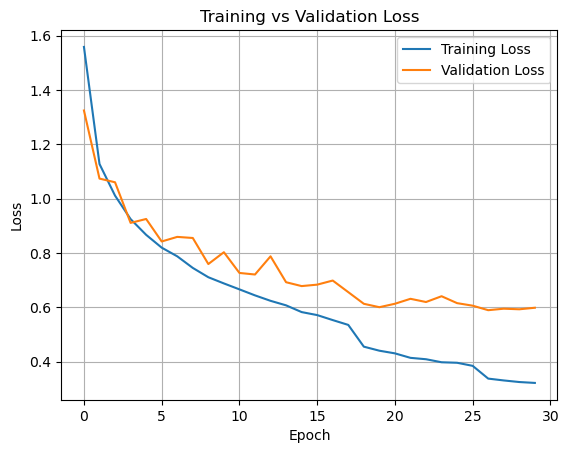

In [11]:
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

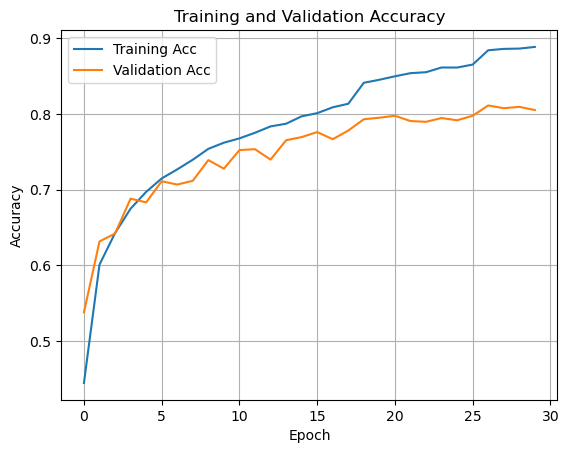

In [12]:
plt.plot(train_accuracies, label="Training Acc")
plt.plot(val_accuracies, label="Validation Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

## Calculate final test score.

In [13]:
test_loss = 0
test_correct = 0
test_total = 0
model.disable_grad()
for X_batch, y_batch in batchloaders['test']:
    
    features = model(X_batch)
    loss = cross_entropy_loss(features, y_batch)
    test_loss += loss.data * len(y_batch.data)
    test_correct += accuracy(features, y_batch)
    test_total += len(y_batch.data)
    
print(f"Test Loss: {(test_loss / test_total):.4f} | Test Accuracy: {(test_correct / test_total):.4f}")

Test Loss: 0.6042 | Test Accuracy: 0.8072
